In [107]:
import pandas as pd

# 确保所有列都能显示出来
pd.set_option('display.max_columns', 500)

# 确保列宽足够，不会把长字符串（比如 Method 名）截断
pd.set_option('display.max_colwidth', 100)

# 确保表格的总宽度足够，不会换行显示
pd.set_option('display.width', 1000)

In [108]:
TASK_METRIC = {
    "cola": ["eval_matthews_correlation"],
    "mnli": ["matched_accuracy", "mismatched_accuracy"],
    "mrpc": ["eval_accuracy", "eval_f1"],
    "qnli": ["eval_accuracy"],
    "qqp": ["eval_accuracy", "eval_f1"],
    "rte": ["eval_accuracy"],
    "sst2": ["eval_accuracy"],
    "stsb": ["eval_pearson", "eval_spearman"],
    "wnli": ["eval_accuracy"],
}

METRIC_NAME_MAP = {
    'eval_matthews_correlation': 'Mcc',
    'matched_accuracy': 'm',
    'mismatched_accuracy': 'mm',
    'eval_accuracy': 'Acc',
    'eval_f1': 'F1',
    'eval_pearson': 'Corr_p',
    'eval_spearman': 'Corr_s',
}

TASK_NAME_MAP = {
    'mnli': 'MNLI',
    'sst2': 'SST-2',
    'cola': 'CoLA',
    'qqp': 'QQP',
    'qnli': 'QNLI',
    'rte': 'RTE',
    'mrpc': 'MRPC',
    'stsb': 'STS-B',
}

FAMILY_NAME_MAP = {
    'bert': 'BERT-b',
    'roberta': 'RoB-b',
    'deberta': 'DeB-b',
}

METHOD_NAME_MAP = {
    'lora': 'LoRA',
    'olora': 'OLoRA',
    'dora': 'DoRA',
    'mrlora': 'MR-LoRA',
    'adalora': 'AdaLoRA',
    'mrlora-rs': 'MR-LoRA-RS',
    'rslora': 'RS-LoRA'
}
VARIANT_NAME_MAP = {
    'fft': 'FFT',
    'lora': 'LoRA-Finetuning',
    'kd-lora': 'KD-LoRA-Finetuning'
}

REMOVE_PEFT = ['mrlora-rs']

In [121]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from dictor import dictor
import seaborn as sns
import matplotlib.pyplot as plt

def extract_experiment_data(json_file):
    variant = Path(json_file).relative_to('./results').parts[0]

    with open(json_file, 'r') as f:
        data = json.load(f)

    data['variant'] = variant
    # with open(json_file, 'w') as f:
    #     json.dump(data, f, indent=4)

    # Extract metadata
    model_family = dictor(data, 'args.model_family')
    peft_method = dictor(data, 'args.peft')
    task = dictor(data, 'args.task')

    eval_runtime = data.get('eval_runtime', -1)

    # Get training-specific metrics
    trainable_params = dictor(data, 'train.trainable_params_count', -1)
    train_runtime = dictor(data, 'train.train_time', -1)

    # Calculate Average GPU Memory (Allocated)
    memory_list = dictor(data, 'train.memory_allocated', [])
    avg_memory = np.mean(memory_list) if memory_list else -1

    rank = dictor(data, 'args.rank')
    if 'mrlora' in peft_method:
        rank = 2*rank - 1 # r = 2*R - 1
        
    # Get metrics
    # Some tasks use eval_accuracy, others eval_matthews_correlation
    for key in TASK_METRIC[task]:
        if key in data:
            accuracy = data[key]
            yield {
                "family": model_family,
                "peft": peft_method,
                "task": task,
                "variant": variant,
                "value": round(accuracy, 4),
                "metric": key,
                "params": round(trainable_params, 4),
                "traintime": round(train_runtime, 2),
                "evaltime": round(eval_runtime, 2),
                "gpumem": round(avg_memory, 2),
                "rank": rank, # total rank.
                'seed': dictor(data, 'args.seed'),
            }


def aggregate_experiment_results(root_dir):
    """
    Finds all .json files under a directory recursively, extracts data,
    and concatenates them into one large DataFrame.
    """
    root_path = Path(root_dir)
    # Recursively find all JSON files
    json_files = list(root_path.rglob("*.json"))

    if not json_files:
        print(f"No JSON files found in {root_dir}")
        return pd.DataFrame()

    all_dfs = []
    for f in json_files:
        try:
            rows = extract_experiment_data(f)
            all_dfs.extend(rows)
        except Exception as e:
            print(f"Failed to extract data from {f}")
            raise e

    if not all_dfs:
        print("No valid data extracted from found files.")
        return pd.DataFrame()

    # Concatenate all individual DataFrames by row
    final_df = pd.DataFrame.from_records(all_dfs)

    return final_df

df = aggregate_experiment_results('./results/')

In [122]:
MODEL_FAMILY = 'bert'
VARIANT = 'kd-lora'
TASK = 'mnli'
METRIC = 'matched_accuracy'
FILENAME = 'fig2-stu.pdf'

df = df[df.variant.isin(['fft', VARIANT])]
df = df[~df.peft.isin(REMOVE_PEFT)]
df = df[df.task == TASK]
df = df[df.metric == METRIC]
df = df[df.family == MODEL_FAMILY]


In [123]:
df = df.groupby('variant peft family task metric rank'.split()).mean().reset_index()
df

,variant,peft,family,task,metric,rank,value,params,traintime,evaltime,gpumem,seed
0,fft,lora,bert,mnli,matched_accuracy,8,0.832800,109.4845,4353.143333,-1.0,1790.320000,729.666667
1,kd-lora,dora,bert,mnli,matched_accuracy,8,0.776000,0.7496,530.730000,-1.0,297.840000,729.666667
2,kd-lora,dora,bert,mnli,matched_accuracy,16,0.775700,0.8970,554.916667,-1.0,300.920000,729.666667
3,kd-lora,dora,bert,mnli,matched_accuracy,32,0.777767,1.1919,516.386667,-1.0,304.520000,729.666667
4,kd-lora,dora,bert,mnli,matched_accuracy,64,0.777467,1.7818,510.156667,-1.0,313.830000,729.666667
5,kd-lora,lora,bert,mnli,matched_accuracy,8,0.773500,0.7404,478.426667,-1.0,301.083333,729.666667
6,kd-lora,lora,bert,mnli,matched_accuracy,16,0.774433,0.8878,445.616667,-1.0,300.283333,729.666667
7,kd-lora,lora,bert,mnli,matched_accuracy,32,0.777400,1.1827,421.296667,-1.0,304.390000,729.666667
8,kd-lora,lora,bert,mnli,matched_accuracy,64,0.776667,1.7725,432.216667,-1.0,313.690000,729.666667
9,kd-lora,mrlora,bert,mnli,matched_accuracy,15,0.795833,0.8694,728.486667,-1.0,301.006667,729.666667


In [124]:
for key, value in METRIC_NAME_MAP.items():
    df.replace(key, value, inplace=True)
for key, value in TASK_NAME_MAP.items():
    df.replace(key, value, inplace=True)
for key, value in METHOD_NAME_MAP.items():
    df.replace(key, value, inplace=True)
for key, value in FAMILY_NAME_MAP.items():
    df.replace(key, value, inplace=True)

## FFT, KD-LoRA, LoRA

In [125]:
df['rank'].unique(), df.family.unique(), df.peft.unique(), df.task.unique(), df.metric.unique(), df.variant.unique()

(array([  8,  16,  32,  64,  15,  31,  63, 127]),
 array(['BERT-b'], dtype=object),
 array(['LoRA', 'DoRA', 'MR-LoRA', 'OLoRA', 'RS-LoRA'], dtype=object),
 array(['MNLI'], dtype=object),
 array(['m'], dtype=object),
 array(['fft', 'kd-lora'], dtype=object))

In [126]:
# 1. Define the Method Label logic
def get_method_name(row):
    if row['variant'] == 'fft':
        return 'FFT'
    else:
        return row['peft']

df['Method'] = df.apply(get_method_name, axis=1)

In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置为 'talk' 模式，这会自动放大所有元素，非常接近论文插图的需求
sns.set_context("talk") 

# 或者手动精细调整
plt.rcParams.update({
    "font.family": "serif",  # 论文通常使用衬线字体
    "font.serif": ["Times New Roman"], # 匹配 LaTeX 默认字体
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.figsize": (8, 6) # 控制画布大小，画布越小，相对字号就越大
})

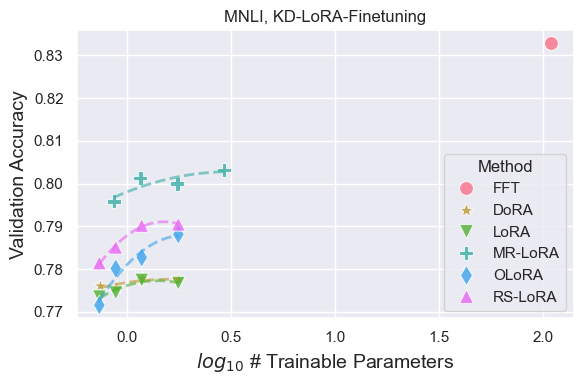

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plot_df = df
# 1. Setup the style
sns.set_theme(style="darkgrid") # Matches the white grid background
# plt.figure(figsize=(10, 6))
# 尝试减小画布尺寸，这样 14pt 的字看起来就会很大
plt.figure(figsize=(6, 4))

# 2. Data Preparation (Ensure log_params exists)
plot_df['log_params'] = np.log10(plot_df['params'])

# 3. Define mapping for markers and colors to ensure consistency
methods = plot_df['Method'].unique()
colors = sns.color_palette("husl", len(methods))
palette_map = dict(zip(methods, colors))
marker_map = {
    'FFT': 'o',          # Circle
    'LoRA': 'v',         # Triangle Down
    'AdaLoRA': 'X',      # Filled X
    'DoRA': '*',         # Star
    'MR-LoRA': 'P',      # Filled Plus
    'OLoRA': 'd',        # Diamond (Replaced '+' to fix the error)
    'RS-LoRA': '^'       # Triangle Up
}
# {'MR-LoRA-RS', 'OLoRA', 'RS-LoRA'}

# 4. Plot using seaborn
ax = sns.scatterplot(
    data=plot_df, 
    x='log_params', 
    y='value', 
    hue='Method', 
    style='Method', 
    palette=palette_map, # Explicitly set colors
    markers=marker_map, 
    s=100,        
    alpha=0.8     
)

# 5. Add Dotted Trend Lines using the palette map
for method in methods:
    subset = plot_df[plot_df['Method'] == method].sort_values('log_params')
    if len(subset) > 1:
        # Fit a 2nd degree polynomial
        z = np.polyfit(subset['log_params'], subset['value'], min(len(subset)-1, 2))
        p = np.poly1d(z)
        x_range = np.linspace(subset['log_params'].min(), subset['log_params'].max(), 100)
        
        # Access color directly from our map to avoid AttributeError
        plt.plot(x_range, p(x_range), linestyle='--', color=palette_map[method], alpha=0.6, linewidth=2)

# 6. Formatting
plt.xlabel('$log_{10}$ # Trainable Parameters', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.legend(title='Method', loc='lower right')
task_name, variant_name = TASK_NAME_MAP[TASK], VARIANT_NAME_MAP[VARIANT]
plt.title(f'{task_name}, {variant_name}')

plt.tight_layout()
plt.savefig(f'./MrLoRA/figures/{FILENAME}', bbox_inches='tight', pad_inches=0.05)
plt.show()